# custom dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import ClassifierSkLearnWrapper
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## [Step 1] Set up an environment

### [Step 1-1] Register a dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to register a dataset and define a `DataFetcher` from the registered dataset. The following codes demonstrate how to register a dataset from arrays of (random) features and (random) labels.

In [2]:
# Set up hyperparameters
dataset_name = "random_dataset"
train_count, valid_count, test_count = 50, 10, 10
noise_rate = 0.1
model_name = "sklogreg"
metric_name = "accuracy"

# Generate a random dataset
X, y= np.random.normal(size=(100, 10)), np.random.choice([0,1], size=100)

In [3]:
# Register a dataset from arrays X and y
pd_dataset = Register(dataset_name=dataset_name, one_hot=True).from_data(X, y)

# After regitering a dataset, we can define `DataFetcher` by its name.
fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(mix_labels, noise_rate=noise_rate)
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a random forest classifier `RandomForestClassifier`. 

In [4]:
# pred_model = ClassifierSkLearnWrapper(LogisticRegression, fetcher.label_dim[0]) # example of Logistic regression
pred_model = ClassifierSkLearnWrapper(RandomForestClassifier, fetcher.label_dim[0])

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [5]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [6]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
#     InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [7]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.014652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76it/s]


Elapsed time LeaveOneOut(): 0:00:08.849377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:46<00:00,  5.76it/s]


Elapsed time DVRL(rl_epochs=2000): 0:05:47.471847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 15850.76it/s]


Elapsed time KNNShapley(k_neighbors=10): 0:00:00.020667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.02it/s]

Elapsed time DataOob(num_models=1000): 0:02:46.083180
CPU times: user 4min 20s, sys: 1.21 s, total: 4min 21s
Wall time: 8min 42s


## [Step 3] Evaluate data values

In [8]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/random_dataset_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [9]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DVRL(rl_epochs=2000),0.181818
DataOob(num_models=1000),0.166667
KNNShapley(k_neighbors=10),0.181818
LeaveOneOut(),0.200000
RandomEvaluator(),0.228571


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

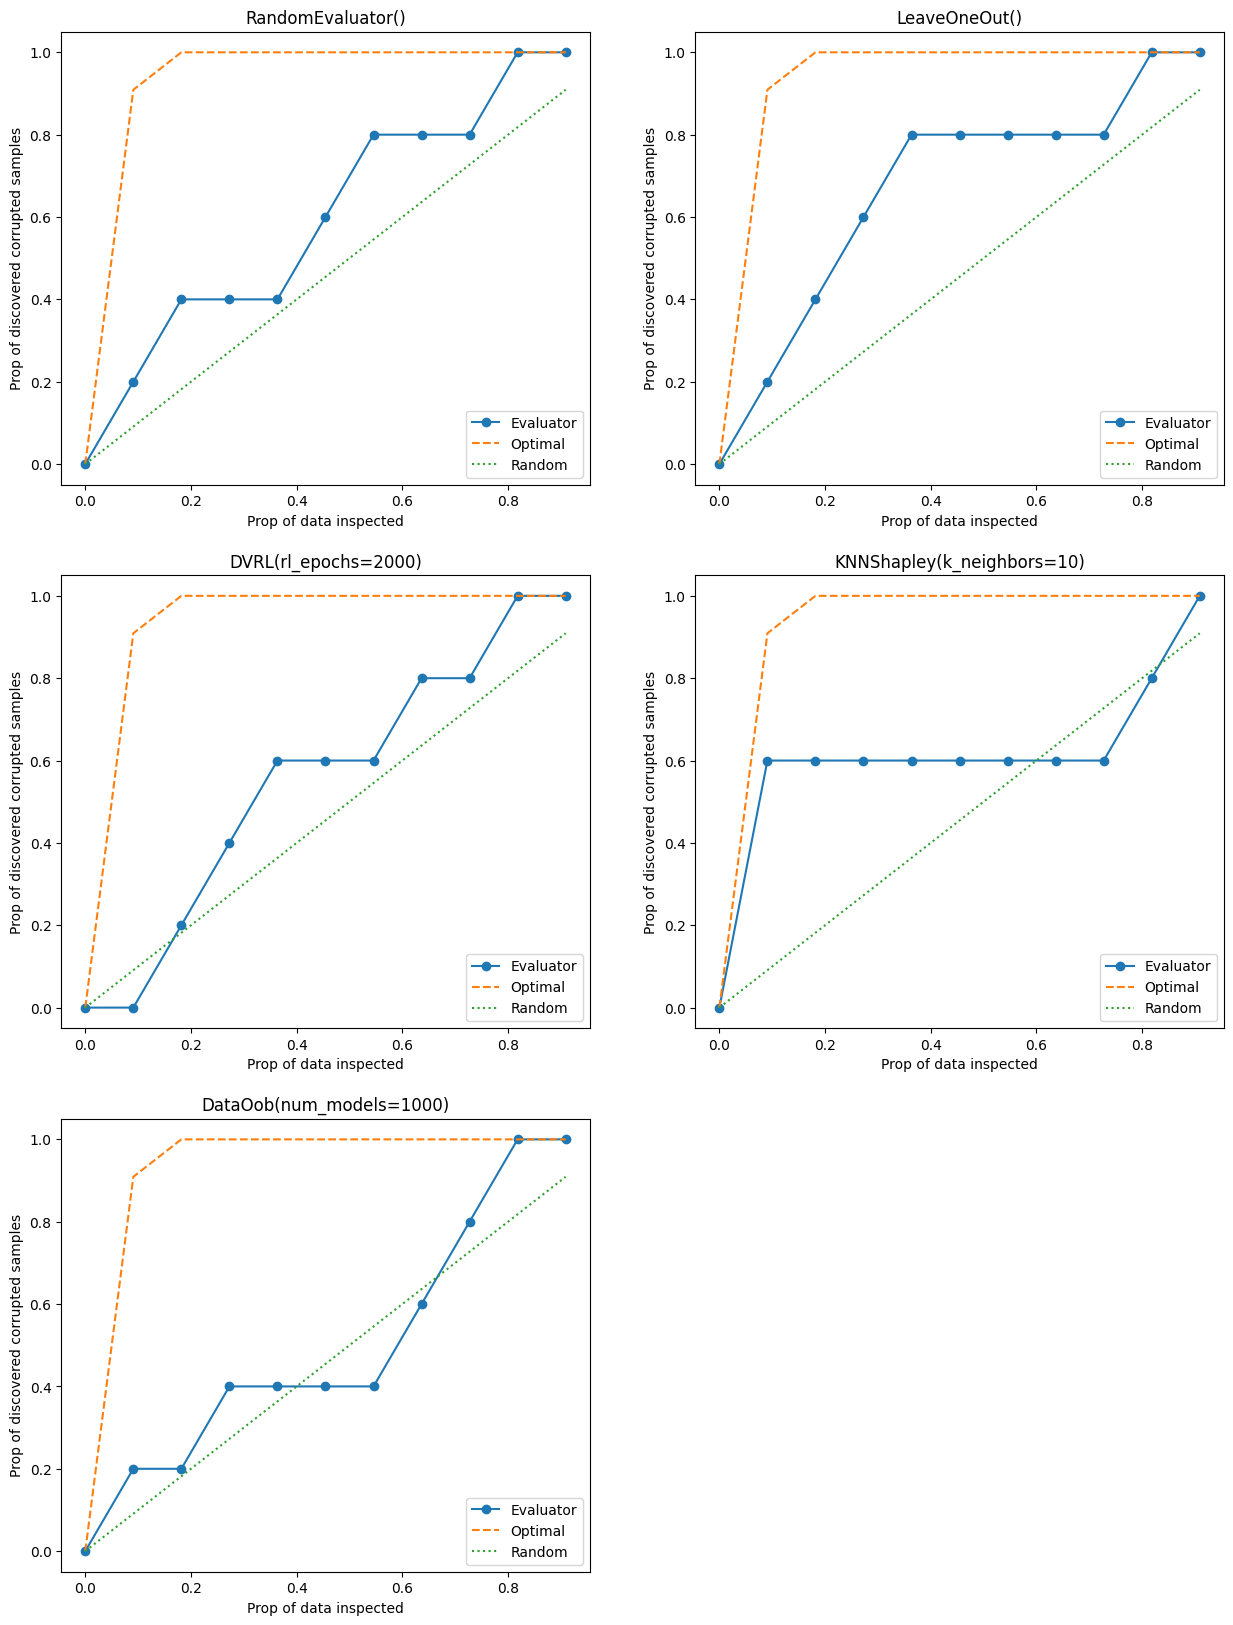

In [14]:
fig = plt.figure(figsize=(15, 20))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

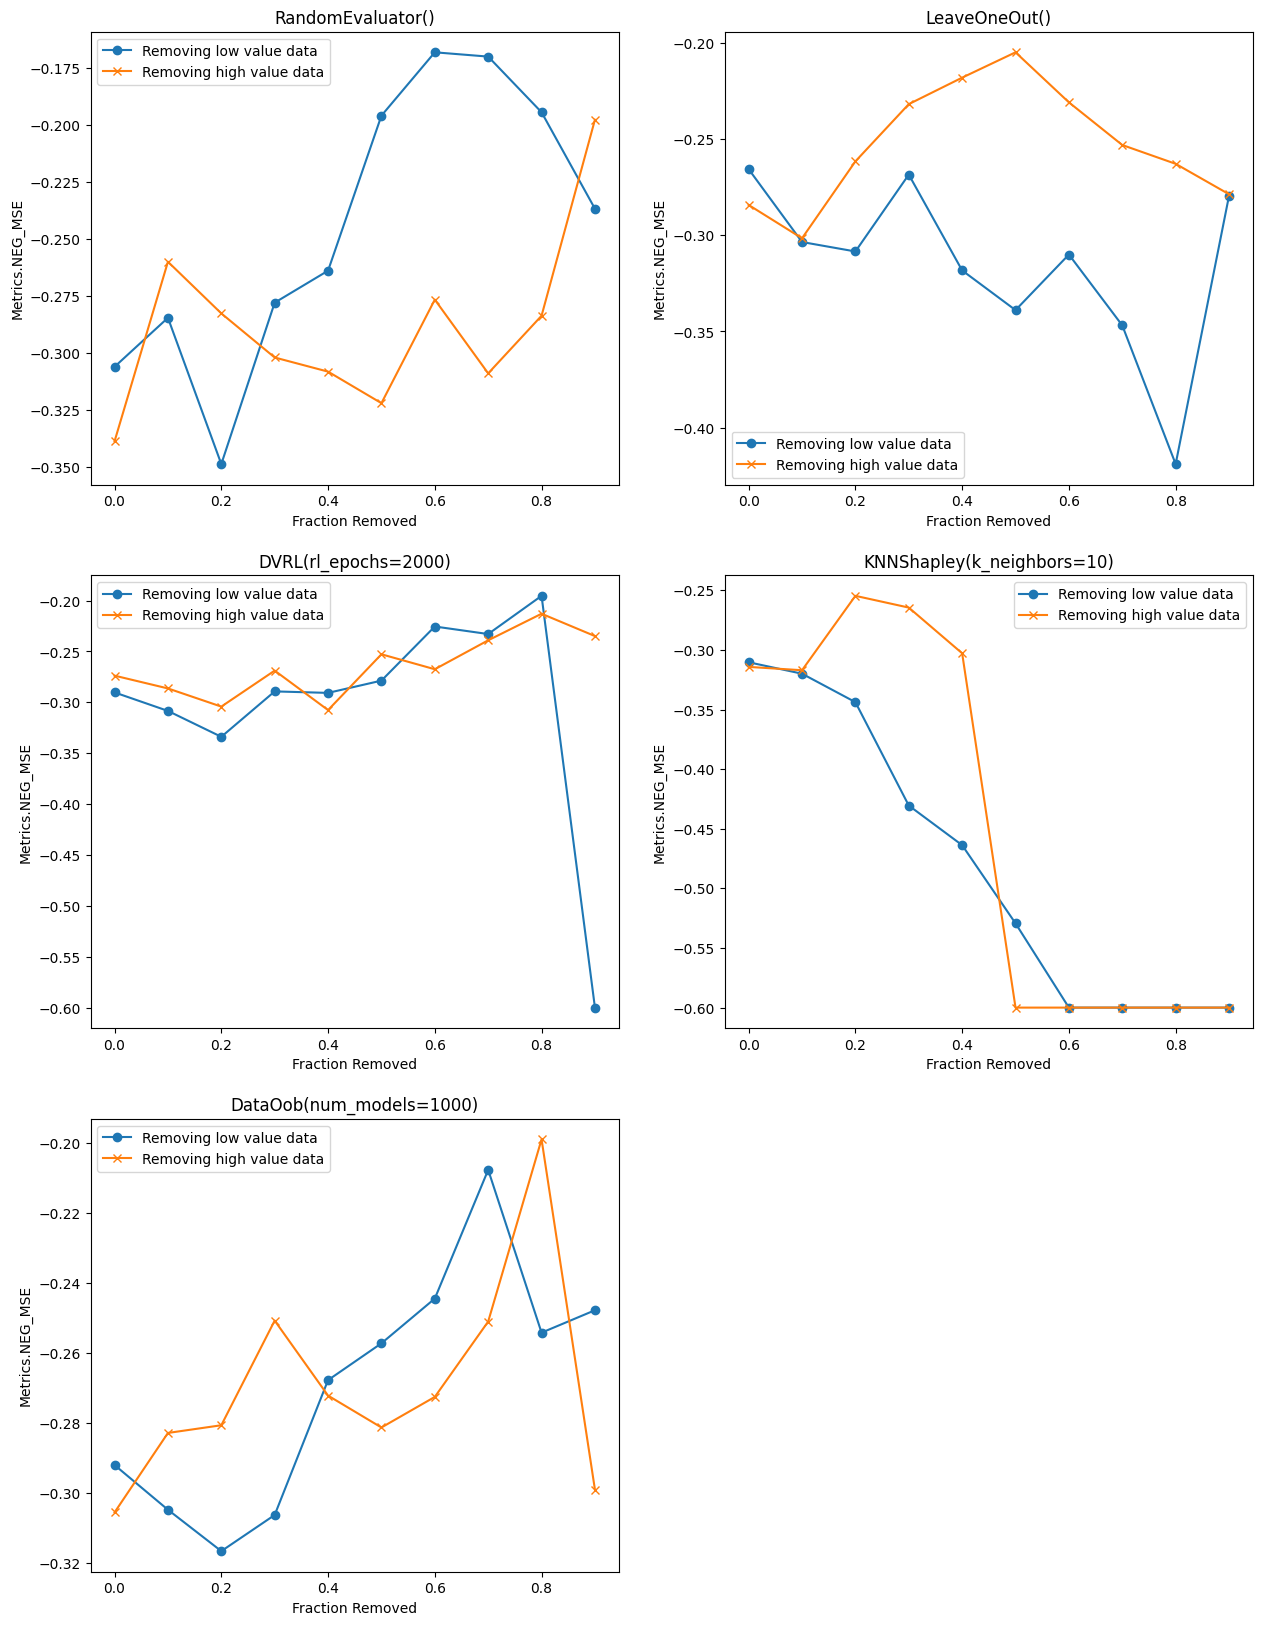

In [15]:
fig = plt.figure(figsize=(15, 20))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [12]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.289,-0.29769,0.0
RandomEvaluator(),-0.31671,-0.2609,0.1
RandomEvaluator(),-0.33516,-0.2623,0.2
RandomEvaluator(),-0.27835,-0.31229,0.3
RandomEvaluator(),-0.26292,-0.27998,0.4
RandomEvaluator(),-0.24349,-0.30296,0.5
RandomEvaluator(),-0.16545,-0.28401,0.6
RandomEvaluator(),-0.16702,-0.30938,0.7
RandomEvaluator(),-0.20882,-0.22194,0.8
RandomEvaluator(),-0.2222,-0.23887,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [13]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),72,0.203624
RandomEvaluator(),64,0.892641
RandomEvaluator(),77,0.618045
RandomEvaluator(),79,0.824838
RandomEvaluator(),50,0.602273
...,...,...
DataOob(num_models=1000),87,-0.242799
DataOob(num_models=1000),37,-0.222095
DataOob(num_models=1000),21,-0.358708
DataOob(num_models=1000),67,-0.101902
